In [43]:
import kagglehub
import os
import cv2
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torchvision import transforms, utils
import torch.nn.functional as F
import torch.nn as nn
from torch import optim
from tqdm import tqdm
from torchsummary import summary

In [2]:
# Download latest version
path = kagglehub.dataset_download("sithukaungset/hairlossdataset")

print("Path to dataset files:", path)

100%|██████████| 347M/347M [00:05<00:00, 66.8MB/s] 

Extracting files...


Path to dataset files: C:\Users\rapco\.cache\kagglehub\datasets\sithukaungset\hairlossdataset\versions\3


In [ ]:
true_path = os.path.join(path, "data0330")

Path to dataset files: C:\Users\rapco\.cache\kagglehub\datasets\sithukaungset\hairlossdataset\versions\3\data0330


In [48]:
class CustomDataset(Dataset):
    def __init__(self, file_paths, labels):
        self.file_paths = file_paths
        self.labels = labels

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        # Load the image using cv2.imread
        img = cv2.imread(self.file_paths[idx])

        if img is None:
            # If the image cannot be read, return an empty image and a default label
            img = np.zeros((32, 32, 3), dtype=np.flo)  # Empty image of shape (640, 640, 3)
            label = torch.tensor(0, dtype=torch.uint8)  # Default label (can be adjusted as needed)
        else:
            # Convert image to RGB and resize it
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert the image to RGB
            img = cv2.resize(img, (32, 32)).astype(np.uint8)  # Resize the image to (640, 640)
            
            label = torch.tensor(self.labels[idx], dtype=torch.uint8)  # Get the label for the image

        return img, label

def prepare_dataset(dataset_path, classes):
    file_paths = []
    labels = []

    # Load images and filter by class
    for class_idx, class_name in enumerate(classes):
        class_path = os.path.join(dataset_path, class_name)
        if os.path.exists(class_path):
            for img_file in os.listdir(class_path):
                file_paths.append(os.path.join(class_path, img_file))
                labels.append(class_idx)

    return CustomDataset(file_paths, labels)

In [37]:
batch_size = 4

classes = ("bald", "notbald")

dataset_filtered = prepare_dataset(true_path, classes)

train_indices, val_indices = train_test_split(range(len(dataset_filtered)), test_size=0.2, random_state=42)

# Use the indices to create subsets for training and validation
train_dataset = Subset(dataset_filtered, train_indices)
val_dataset = Subset(dataset_filtered, val_indices)

# Create DataLoader for both training and validation sets
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


Images data shape: torch.Size([4, 3, 32, 32])
Label raw data: tensor([1, 0, 0, 0], dtype=torch.uint8)

Example of training set batch:


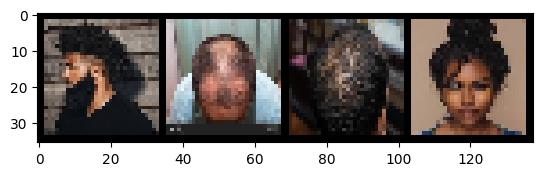

Actual Labels:  notbald	bald 	bald 	bald 


In [38]:
def imshow(img):
    # Unnormalize pixels
    npimg = img.numpy()
    # Put image into shape (32, 32, 3) to display
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get random training image batch
dataiter = iter(train_dataloader)
images, labels = next(dataiter)

images = images.permute(0, 3, 1, 2)

print(f'Images data shape: {images.shape}')
print(f'Label raw data: {labels}\n')

# Show images
print("Example of training set batch:")
imshow(utils.make_grid(images))
# Print labels
print('Actual Labels: ', '\t'.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

Simple CNN for Training

In [39]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(in_features=256 * 2 * 2, out_features=256)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(in_features=256, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=64)
        self.fc4 = nn.Linear(in_features=64, out_features=10)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x)))) # Adds Layers 1-3
        x = self.pool(F.relu(self.bn2(self.conv2(x)))) # Adds Layers 4-6
        x = self.pool(F.relu(self.bn3(self.conv3(x))))    # Adds Layers 7-9
        x = self.pool(F.relu(self.bn4(self.conv4(x))))    # Adds Layers 10-12
        x = torch.flatten(x, 1)  # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x =  F.relu(self.fc3(x))
        x =  self.fc4(x)
        return x

In [46]:
device = "cuda" if torch.cuda.is_available() else "cpu"  # Use GPU if possible

simple_model = SimpleCNN().to(device)
summary(simple_model, input_size=(3, 32, 32))
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(simple_model.parameters(), lr=0.001, momentum=0.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
       BatchNorm2d-2           [-1, 32, 32, 32]              64
         MaxPool2d-3           [-1, 32, 16, 16]               0
            Conv2d-4           [-1, 64, 16, 16]          18,496
       BatchNorm2d-5           [-1, 64, 16, 16]             128
         MaxPool2d-6             [-1, 64, 8, 8]               0
            Conv2d-7            [-1, 128, 8, 8]          73,856
       BatchNorm2d-8            [-1, 128, 8, 8]             256
         MaxPool2d-9            [-1, 128, 4, 4]               0
           Conv2d-10            [-1, 256, 4, 4]         295,168
      BatchNorm2d-11            [-1, 256, 4, 4]             512
        MaxPool2d-12            [-1, 256, 2, 2]               0
           Linear-13                  [-1, 256]         262,400
          Dropout-14                  [

In [59]:
def train(model, loader, criterion, optimizer, epochs=2):
  '''Train a model from training data.

  Args:
    - model: Neural network to train
    - epochs: Number of epochs to train the model
    - loader: Dataloader to train the model with
  '''
  print('Start Training')

  for epoch in range(epochs):  # loop over the dataset multiple times

      running_loss = 0.0
      total = 0
      correct = 0
      for i, data in enumerate(tqdm(loader)):
          # get the inputs; data is a list of [inputs, labels]
          inputs, labels = data

          if (inputs == 0).all():  # Check if all pixels are zero
            continue

          # zero the parameter gradients
          optimizer.zero_grad()

          inputs, labels = inputs.to(device), labels.to(device)

          # forward + backward + optimize
          inputs = inputs.permute(0, 3, 1, 2)  # Reorder dimensions for correct input shape
          outputs = model(inputs.float())  # Ensure the inputs are in float32

          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()

          # the class with the highest energy is what we choose as prediction
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

          # print statistics
          running_loss += loss.item()
          if i % 100 == 99:    # print every 2000 mini-batches
              print(f'[epoch {epoch + 1}, batch {i + 1:5d}] loss: {running_loss / 100:.3f}')
              running_loss = 0.0

              print(f'\nAccuracy of the network on last 100 training images: {100 * correct // total} %')
              total = 0
              correct = 0
      scheduler.step()

  print('\nFinished Training')

In [60]:
train(simple_model, train_dataloader, criterion, optimizer, epochs=10)

Start Training


 45%|████▌     | 101/223 [00:05<00:06, 19.83it/s]

[epoch 1, batch   100] loss: 0.268

Accuracy of the network on last 100 training images: 88 %


 91%|█████████ | 203/223 [00:10<00:00, 27.04it/s]

[epoch 1, batch   200] loss: 0.384

Accuracy of the network on last 100 training images: 85 %


 44%|████▍     | 99/223 [00:05<00:06, 19.24it/s]

[epoch 2, batch   100] loss: 0.304

Accuracy of the network on last 100 training images: 88 %


 91%|█████████ | 203/223 [00:10<00:01, 16.24it/s]

[epoch 2, batch   200] loss: 0.306

Accuracy of the network on last 100 training images: 87 %


 45%|████▌     | 101/223 [00:06<00:07, 16.13it/s]

[epoch 3, batch   100] loss: 0.196

Accuracy of the network on last 100 training images: 91 %


 90%|█████████ | 201/223 [00:10<00:00, 22.53it/s]

[epoch 3, batch   200] loss: 0.168

Accuracy of the network on last 100 training images: 94 %


 44%|████▍     | 99/223 [00:04<00:08, 14.92it/s]

[epoch 4, batch   100] loss: 0.102

Accuracy of the network on last 100 training images: 97 %


 90%|████████▉ | 200/223 [00:10<00:01, 19.72it/s]

[epoch 4, batch   200] loss: 0.253

Accuracy of the network on last 100 training images: 91 %


 45%|████▍     | 100/223 [00:05<00:05, 23.60it/s]

[epoch 5, batch   100] loss: 0.139

Accuracy of the network on last 100 training images: 95 %


 91%|█████████▏| 204/223 [00:10<00:00, 19.19it/s]

[epoch 5, batch   200] loss: 0.067

Accuracy of the network on last 100 training images: 98 %


 21%|██        | 46/223 [00:03<00:12, 14.18it/s]


KeyboardInterrupt: 

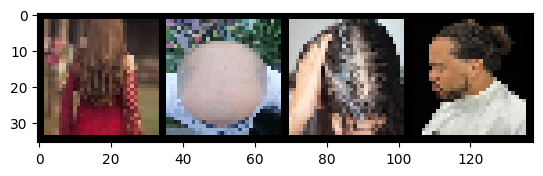

Ground Truth:    notbald	bald 	notbald	notbald
CNN prediction:  notbald	bald 	notbald	notbald


In [67]:
dataiter = iter(val_dataloader)
images, labels = next(dataiter)

images = images.permute(0, 3, 1, 2)

# print images from test set
imshow(utils.make_grid(images))
print('Ground Truth:   ', '\t'.join(f'{classes[labels[j]]:5s}' for j in range(4)))

# Input images into model and see ouptut

images, labels = images.to(device), labels.to(device)

outputs = simple_model(images.float())
_, predicted = torch.max(outputs, 1)

print('CNN prediction: ', '\t'.join(f'{classes[predicted[j]]:5s}' for j in range(4)))

In [ ]:
def evaluation(model, loader):
  '''Evaluate a model and output its accuracy on a test dataset.

  Args:
    - model: Neural network to evaluate
    - loader: Dataloader containing test dataset
  '''
  # Evaluate accuracy on validation / test set
  correct = 0
  total = 0
  # since we're not training, we don't need to calculate the gradients for our outputs
  with torch.no_grad():
      for data in tqdm(loader):
          images, labels = data

          if (images == 0).all():  # Check if all pixels are zero
            continue
          # calculate outputs by running images through the network

          images, labels = images.to(device), labels.to(device)

          images = images.permute(0, 3, 1, 2)
          outputs = model(images.float())
          # the class with the highest energy is what we choose as prediction
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

  print(f'\nAccuracy of the network on the 10000 test images: {100 * correct // total} %')

In [ ]:
evaluation(simple_model, val_dataloader)